## W210 Capston Project - ASD Diagnosis
## EDA

## Setup and Imports

In [1]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [5]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import seaborn as sns
import random as r
import cv2
from tabulate import tabulate
from scipy import stats
import warnings
import statsmodels.api as sm


c:\Users\waqasali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\waqasali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [6]:
warnings.filterwarnings("ignore")

## TC and TS Images EDA

In [7]:
# Load both TC (non-ASD) and TS (ASD) images from the directlty into separate lists.
def read_png_images_from_directory(directory_path):
    image_list = []
    
    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Directory '{directory_path}' does not exist.")
        return image_list

    for filename in os.listdir(directory_path):
        if filename.endswith(".png"):
            file_path = os.path.join(directory_path, filename)
            try:
                image = Image.open(file_path)
                image_list.append(image)
            except Exception as e:
                print(f"Error reading {filename}: {str(e)}")

    return image_list

if __name__ == "__main__":
    # Path to the directory containing .png TCimages (non-ASD)
    tc_directory_path = '../data/extracted/Images/TCImages'  
    # Path to the directory containing .png TSimages (ASD)
    ts_directory_path = '../data/extracted/Images/TSImages'  

    tc_images = read_png_images_from_directory(tc_directory_path)
    ts_images = read_png_images_from_directory(ts_directory_path)

    if len(tc_images) > 0:
        print(f"Successfully loaded {len(tc_images)} .png images.")
        # You can work with the images in the 'png_images' list here.
    if len(ts_images) > 0:
        print(f"Successfully loaded {len(ts_images)} .png images.")
        # You can work with the images in the 'png_images' list here.
    else:
        print("No .png images found in the specified directory.")


Successfully loaded 328 .png images.
Successfully loaded 219 .png images.


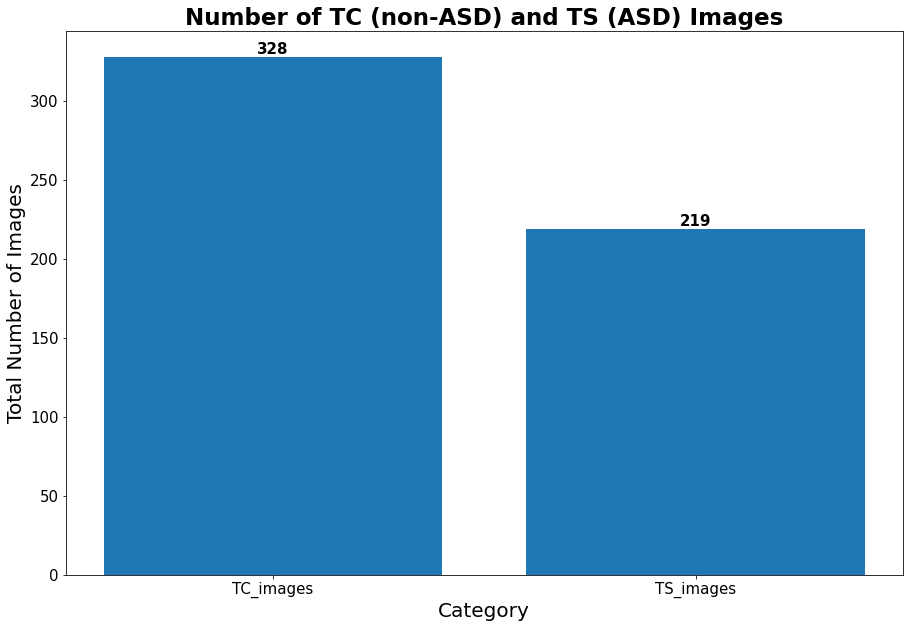

In [8]:
# Barplot to see how many TC and TS images are present in the dataset
list_lengths = [len(tc_images), len(ts_images)]

# Create a list of labels for the bars (optional)
list_labels = ['TC_images', 'TS_images']

# Create the bar plot
plt.figure(figsize=(15,10))
bars = plt.bar(list_labels, list_lengths)

# Set the font size for x and y-axis labels
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', fontsize=15, fontweight = "bold")

# Add labels and a title
plt.xlabel('Category', fontsize = 20)
plt.ylabel('Total Number of Images', fontsize = 20)
plt.title('Number of TC (non-ASD) and TS (ASD) Images', fontsize = 23, fontweight = 'bold')

# Show the plot
plt.show()


In [9]:
# check if all tc and ts images are of the same size

image_size = tc_images[0].size

for image in tc_images:
    if image.size == image_size:
        pass
    else:
        print("size mismatch")
print('All TC images are of the same size')

for image in ts_images:
    if image.size == image_size:
        pass
    else:
        print("size mismatch")
print('All TS images are of the same size')

All TC images are of the same size
All TS images are of the same size


In [10]:
# Image characteristics

print('Image Size:', image_size)
print('Image Type:', tc_images[0].mode) # Alphe channel represents opacity of the imag: 0 = transparent and 255 = fully opaque

Image Size: (640, 480)
Image Type: RGBA


"Alpha" channel represents opacity of the imag: 0 = transparent and 255 = fully opaque

## Metadata EDA

In [11]:
# Load metadata json file from the directory and convert it into a pandas data frame

# path to the JSON file
json_file_path = '../data/metadata/data.json'

with open(json_file_path, 'r') as file:
    data = json.load(file)

# Flatten the JSON data
df = pd.json_normalize(data)

df_tc = pd.DataFrame(df.TCImages[0])
df_ts = pd.DataFrame(df.TSImages[0])

df = pd.merge(df_tc, df_ts, how='outer')

df['Age'] = pd.to_numeric(df['Age'], errors='coerce', downcast='float')
df['ParticipantID'] = pd.to_numeric(df['ParticipantID'], errors='coerce', downcast='float')
df['CARS'] = df['CARS'].fillna(0)

df

,File,ParticipantID,Age,Gender,CARS
0,TC001_39.png,39.0,8.6,M,0.0
1,TC002_39.png,39.0,8.6,M,0.0
2,TC003_37.png,37.0,12.8,F,0.0
3,TC004_37.png,37.0,12.8,F,0.0
4,TC005_37.png,37.0,12.8,F,0.0
...,...,...,...,...,...
542,TS231_23.png,23.0,3.2,M,32.0
543,TS232_23.png,23.0,3.2,M,32.0
544,TS233_23.png,23.0,3.2,M,32.0
545,TS234_23.png,23.0,3.2,M,32.0


In [12]:
df.describe(include='all')

,File,ParticipantID,Age,Gender,CARS
count,547,547.000000,547.000000,547,547.000000
unique,547,NaN,NaN,2,NaN
top,TC001_39.png,NaN,NaN,M,NaN
freq,1,NaN,NaN,343,NaN
mean,NaN,31.186472,8.278963,NaN,12.126143
std,NaN,17.734568,2.758269,NaN,15.343103
min,NaN,1.000000,2.700000,NaN,0.000000
25%,NaN,15.000000,6.150000,NaN,0.000000
50%,NaN,34.000000,8.200000,NaN,0.000000
75%,NaN,47.000000,10.700000,NaN,27.000000


- There are 547 total images. 328 TC and 219 TS images.
- Participant ID - A unique ID assigned to each participant
- Age - Age of each participant
- Gender - Gender of each participant
- CARS - A score assigned to each participant based on the severity of the ASD condition. For non-ASD participants the score is 0.

In [13]:
# There are multiple rows for the same participant. This is not duplication becuase those multiple rows from same participant contain different image.
# But to look at Age, Gender and CARS statistics we need to look at unique participants 

df_participants = df.drop_duplicates(subset=['ParticipantID'])
df_participants

,File,ParticipantID,Age,Gender,CARS
0,TC001_39.png,39.0,8.6,M,0.0
2,TC003_37.png,37.0,12.8,F,0.0
5,TC006_33.png,33.0,5.8,F,0.0
9,TC010_52.png,52.0,10.7,M,0.0
10,TC016_54.png,54.0,3.7,M,0.0
22,TC028_30.png,30.0,6.7,F,0.0
25,TC031_36.png,36.0,8.9,F,0.0
28,TC034_31.png,31.0,8.8,F,0.0
36,TC042_40.png,40.0,8.2,F,0.0
44,TC050_35.png,35.0,4.2,M,0.0


In [14]:
print('Total Number of Participants:', len(df_participants))

Total Number of Participants: 54


In [15]:
df_participants.describe(include='all')

,File,ParticipantID,Age,Gender,CARS
count,54,54.000000,54.000000,54,54.000000
unique,54,NaN,NaN,2,NaN
top,TC001_39.png,NaN,NaN,M,NaN
freq,1,NaN,NaN,35,NaN
mean,NaN,29.907408,8.061111,NaN,15.555556
std,NaN,17.762871,2.823046,NaN,16.894140
min,NaN,1.000000,2.700000,NaN,0.000000
25%,NaN,14.250000,5.800000,NaN,0.000000
50%,NaN,30.500000,8.200000,NaN,0.000000
75%,NaN,45.750000,10.475000,NaN,32.375000


### AGE Distribution of the Participants

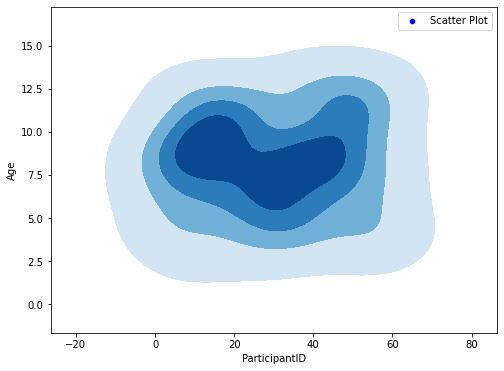

In [16]:
#Scatter plot of particpants age

plt.figure(figsize=(8,6))
sns.scatterplot('ParticipantID', 'Age', data=df_participants, color='blue', label='Scatter Plot')
sns.kdeplot(df_participants['ParticipantID'], df_participants['Age'], cmap='Blues', fill=True, levels=5)
plt.show()


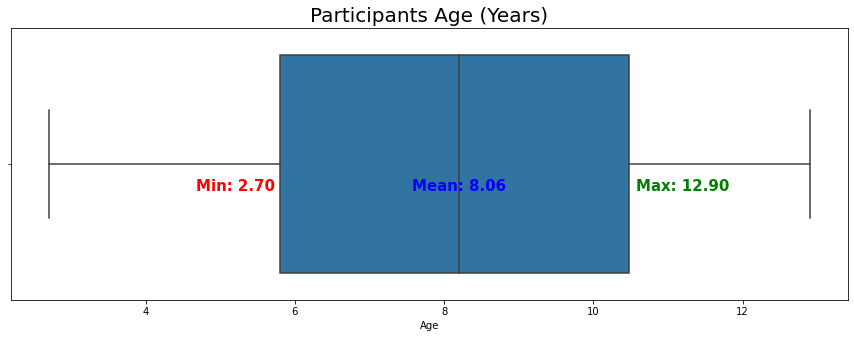

In [17]:
# Box plot of the participants age

plt.figure(figsize=(15, 5))  
sns.boxplot(df_participants['Age'])

# Calculate statistics: min, max, and mean
min_val = df_participants['Age'].min()
max_val = df_participants['Age'].max()
mean_val = df_participants['Age'].mean()

# Add labels to the box
y_position_min = min_val - 2.6  
y_position_max = min_val - 2.6  
y_position_mean = min_val - 2.6  

plt.text(5.2, y_position_min, f"Min: {min_val:.2f}", ha="center", fontsize=15, color='red', fontweight = 'bold')
plt.text(11.2, y_position_max, f"Max: {max_val:.2f}", ha="center", fontsize=15, color='green', fontweight = 'bold')
plt.text(8.2, y_position_mean, f"Mean: {mean_val:.2f}", ha="center", fontsize=15, color='blue', fontweight = 'bold')


# Add a title
plt.title('Participants Age (Years)', fontsize=20, color='black')

# Show the plot
plt.show()

### CARS Distribution for ASD participants

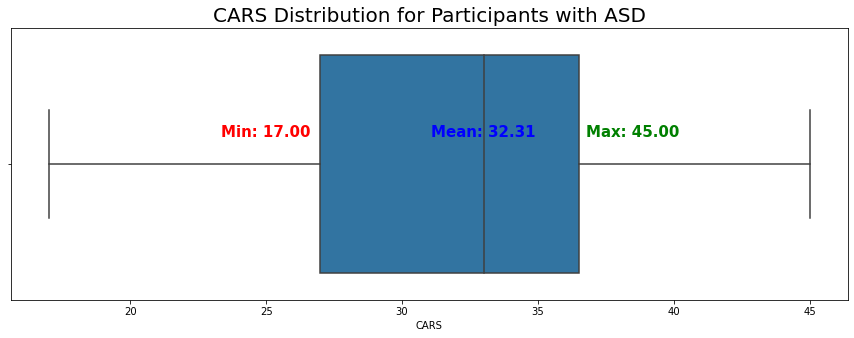

In [18]:
# Create a box plot of the 'Values' column
data = df_participants[df_participants['CARS'] != 0.0]['CARS']

plt.figure(figsize=(15, 5))  
sns.boxplot(data) 

# Calculate statistics: min, max, and mean
min_val = data.min()
max_val = data.max()
mean_val = data.mean()

# Add labels to the box
y_position_min = min_val - 17.1  
y_position_max = min_val - 17.1  
y_position_mean = min_val - 17.1 

plt.text(25, y_position_min, f"Min: {min_val:.2f}", ha="center", fontsize=15, color='red', fontweight = 'bold')
plt.text(38.5, y_position_max, f"Max: {max_val:.2f}", ha="center", fontsize=15, color='green', fontweight = 'bold')
plt.text(33, y_position_mean, f"Mean: {mean_val:.2f}", ha="center", fontsize=15, color='blue', fontweight = 'bold')


# Add a title
plt.title('CARS Distribution for Participants with ASD', fontsize=20, color='black')

# Show the plot
plt.show()

### Participants GENDER Disctribution

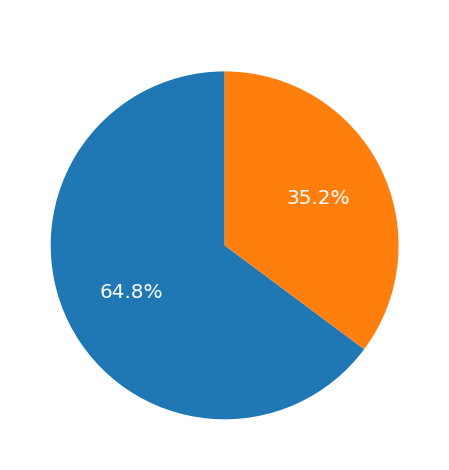

In [19]:
category_counts = df_participants['Gender'].value_counts()


plt.figure(figsize=(8, 8)) 
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 20, 'color': 'white'})

# Add a title
plt.title('Gender Distribution', fontsize=20, color='white')

# Show the plot
plt.show()


## Feature Engineering

### Display 8 randomly selected TC and TS images

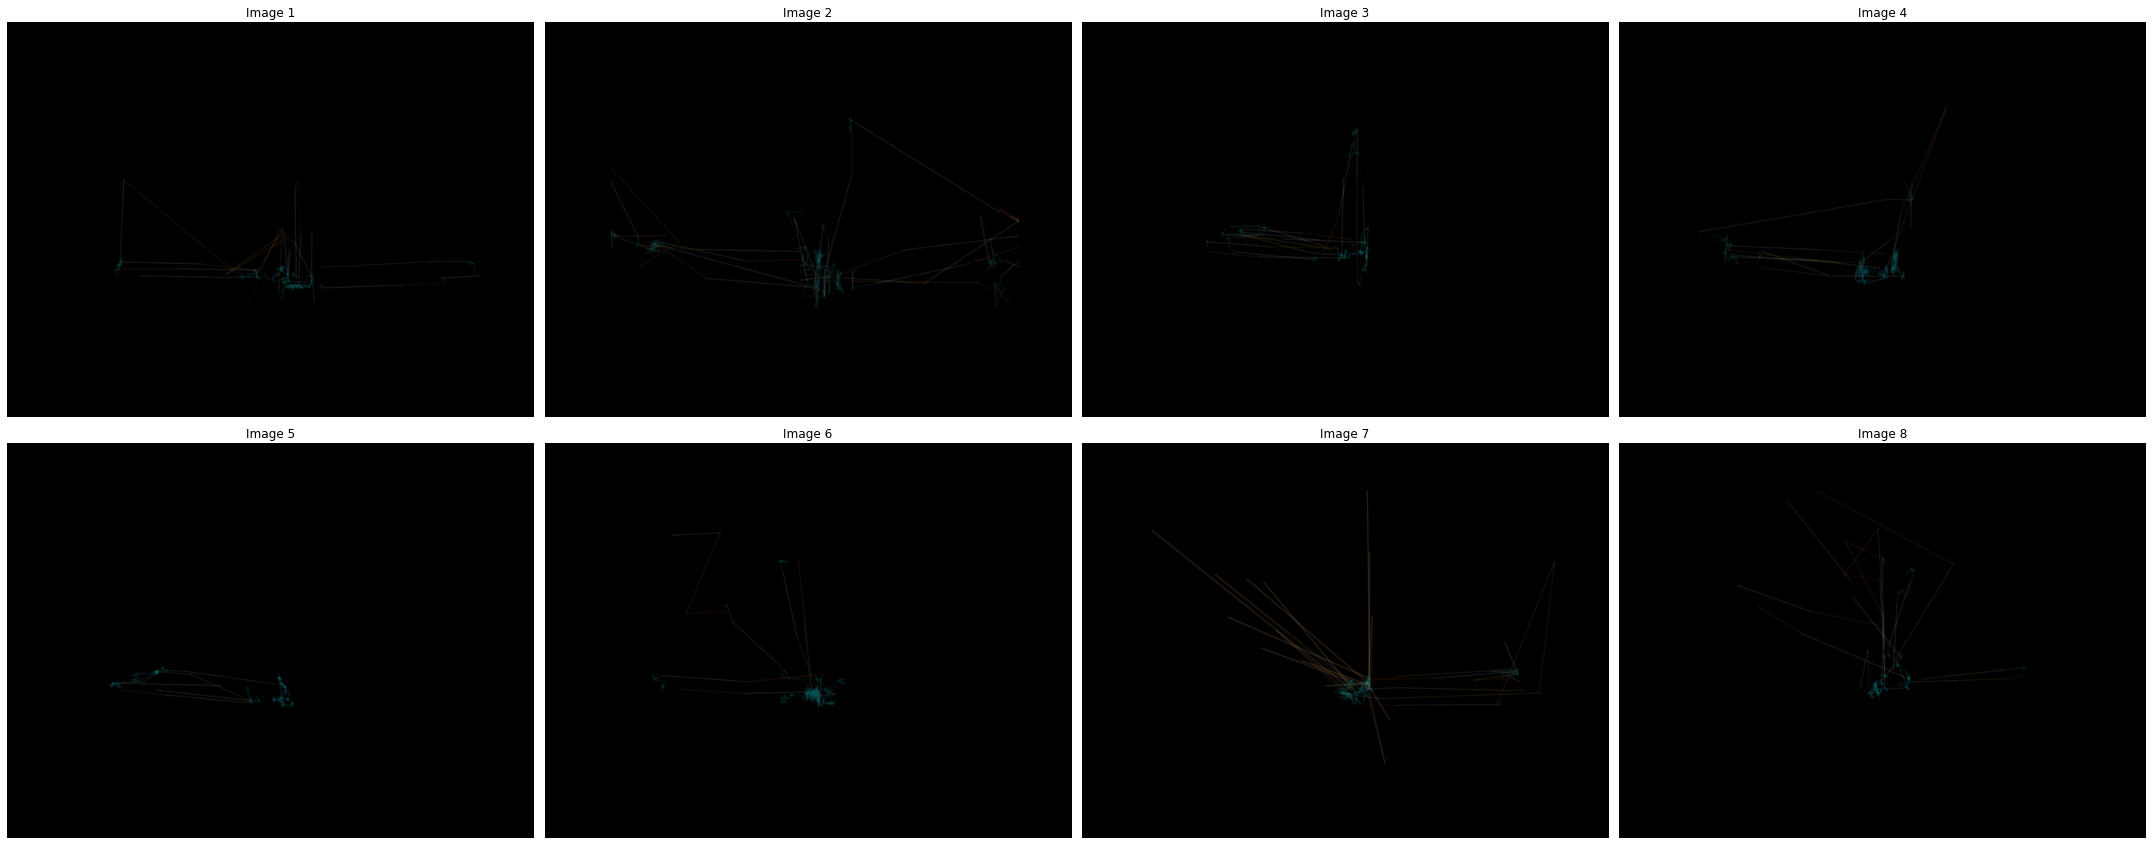

In [20]:
# Randomly select 8 images from the TC image list
sample_tcimages = r.sample(tc_images, 8)

# Define the number of rows and columns in the grid
rows, cols = 2, 4

# Create a figure and a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(30, 12))

# Flatten the 2D grid of subplots
axes = axes.flatten()

# Loop through the images and plot them on the subplots
for i in range(len(sample_tcimages)):
    axes[i].imshow(sample_tcimages[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    axes[i].set_title(f'Image {i + 1}')
    axes[i].axis('off')  # Turn off axis labels

# Adjust the layout
plt.tight_layout()

# Show the grid of images
plt.show()

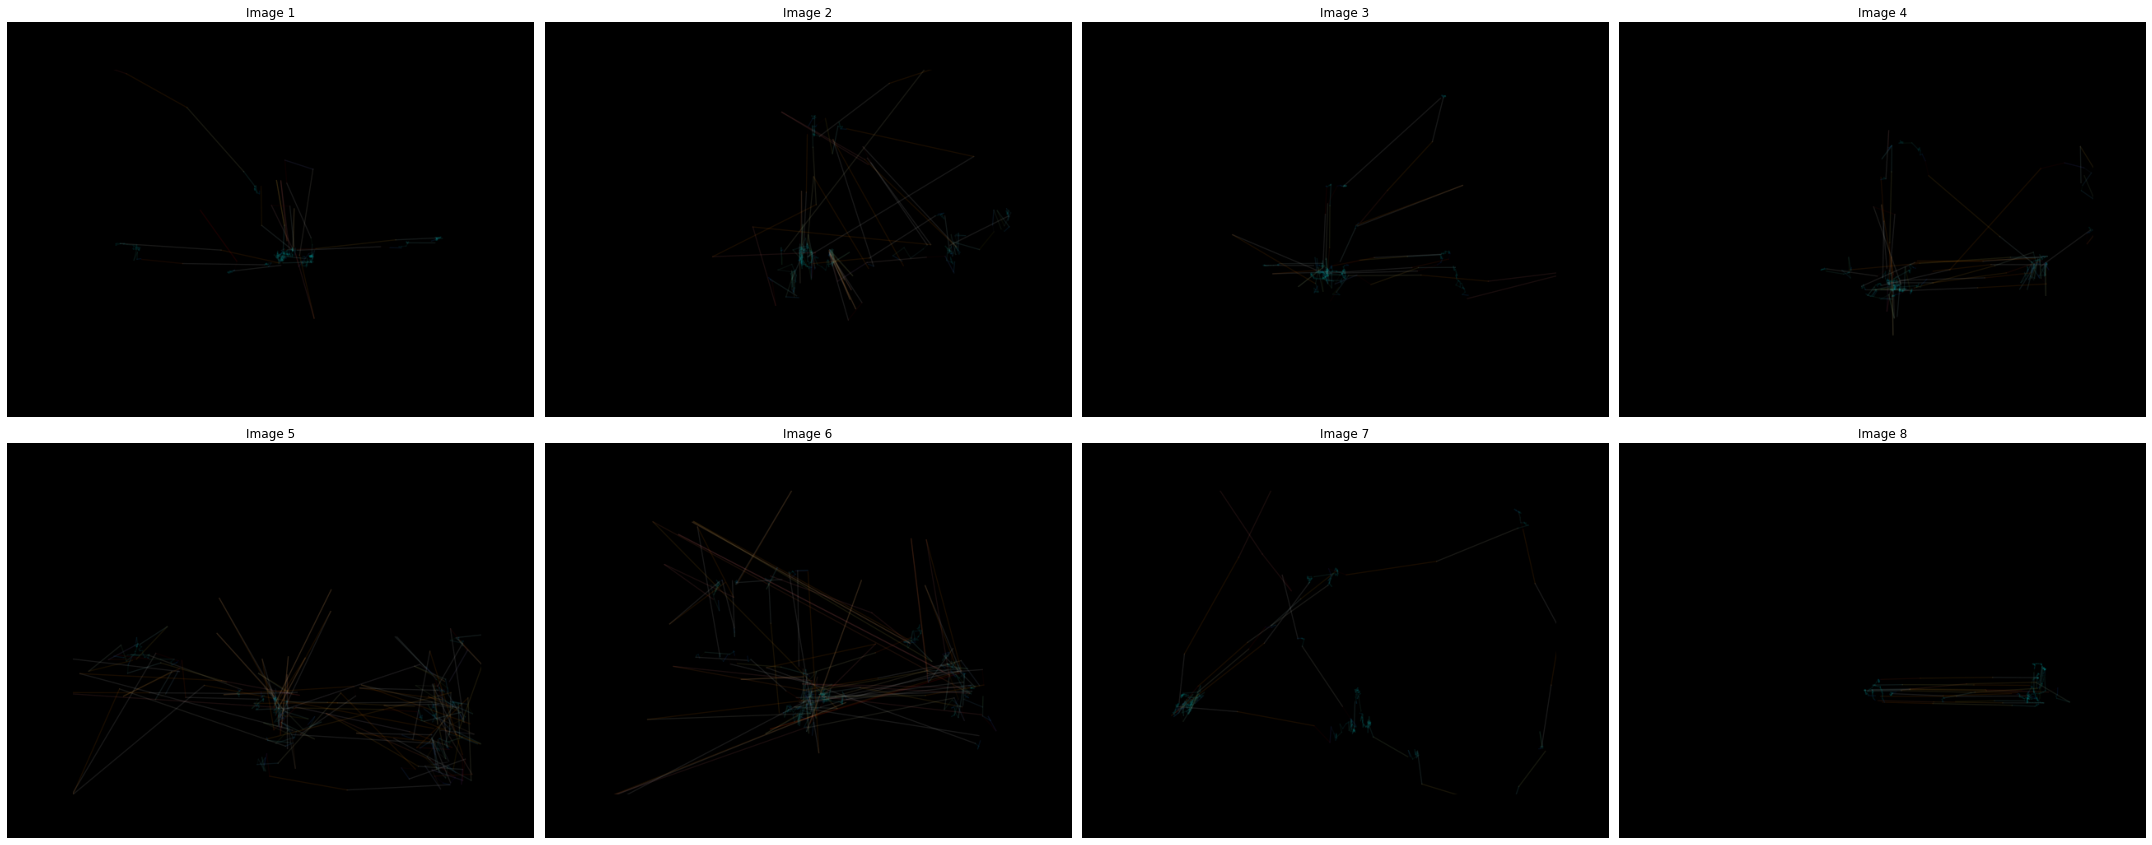

In [21]:
# Randomly select 8 elements from the TC image list
sample_tsimages = r.sample(ts_images, 8)

# Define the number of rows and columns in the grid
rows, cols = 2, 4

# Create a figure and a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(30, 12))

# Flatten the 2D grid of subplots
axes = axes.flatten()

# Loop through the images and plot them on the subplots
for i in range(len(sample_tsimages)):
    axes[i].imshow(sample_tsimages[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    axes[i].set_title(f'Image {i + 1}')
    axes[i].axis('off')  # Turn off axis labels

# Adjust the layout
plt.tight_layout()

# Show the grid of images
plt.show()

### Change image background from black to white for better visualization

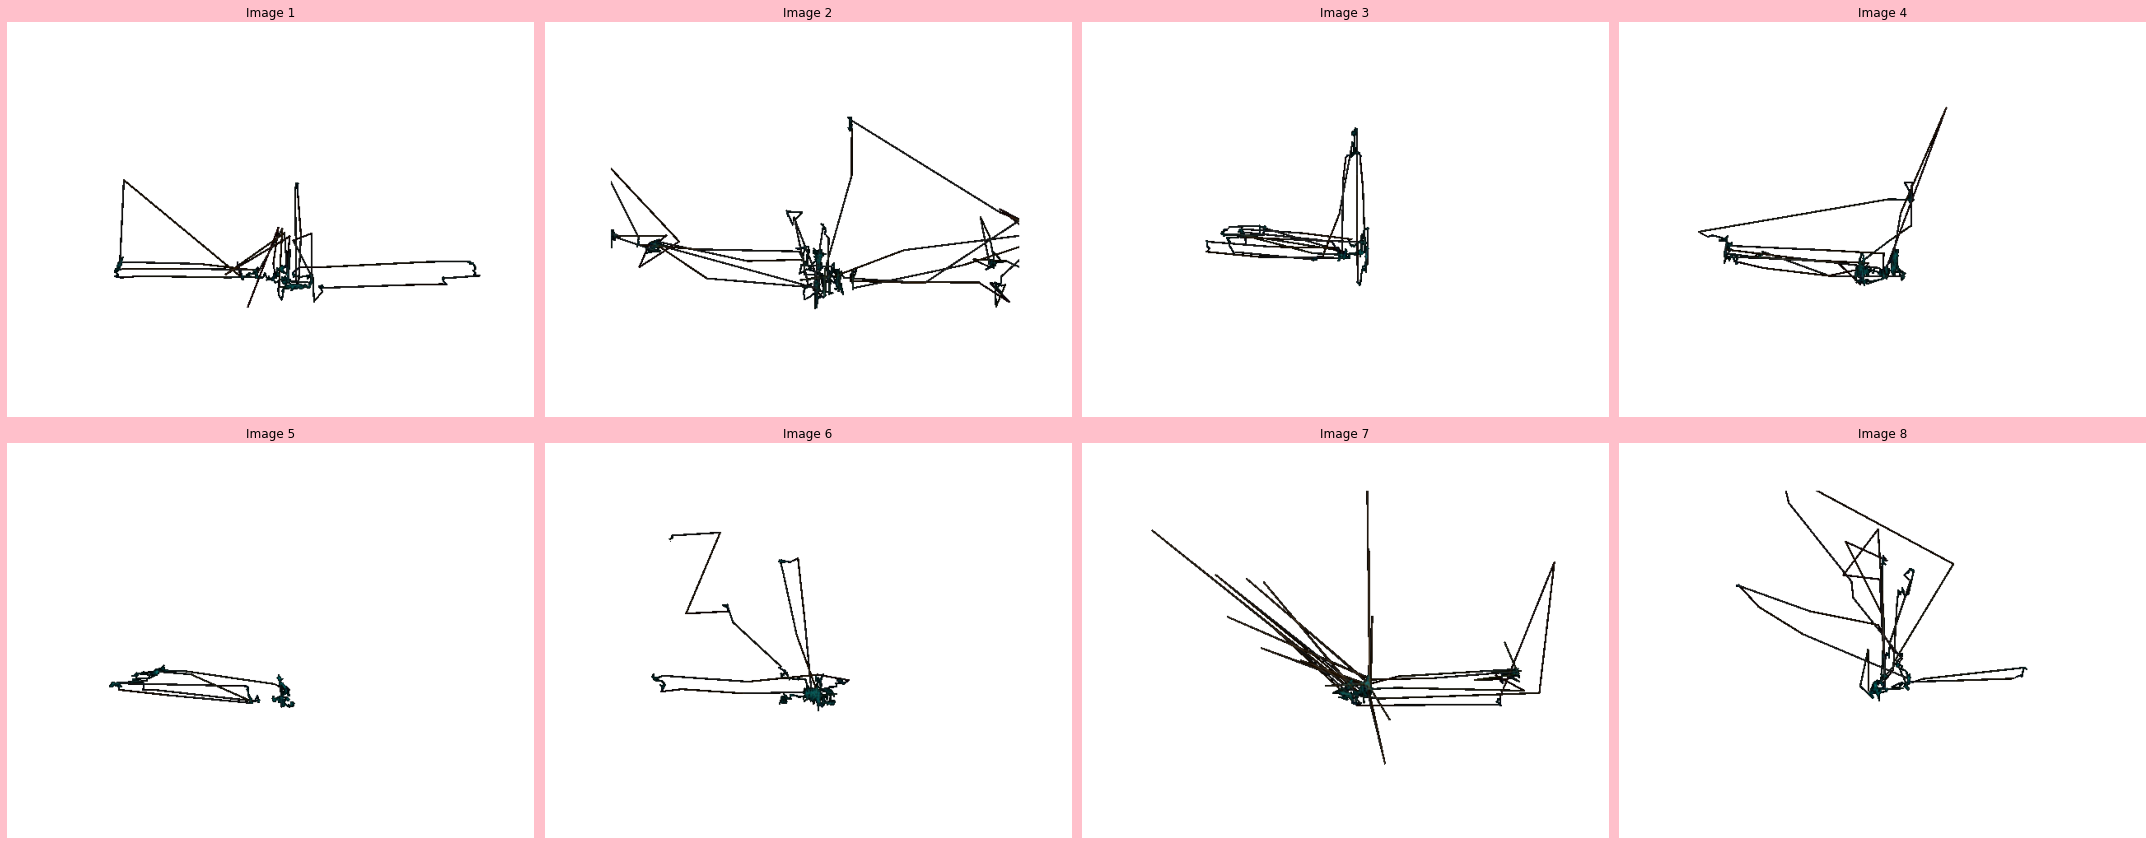

In [22]:
# For TC images

sample_tcimages_white_bg = []

for image in sample_tcimages:
    
    # Create a NumPy array from the image data
    image_data = np.array(image)

    # Create a mask for black regions (assuming black is [0, 0, 0, 255] in RGBA)
    black_mask = np.all(image_data[:, :, :3] == [0, 0, 0], axis=2)

    # Replace black regions with white (255, 255, 255, 255)
    image_data[black_mask] = [255, 255, 255, 255]

    # Convert the modified NumPy array back to an image
    image = Image.fromarray(image_data)

    # Save the modified image
    sample_tcimages_white_bg.append(image)

# Define the number of rows and columns in the grid
rows, cols = 2, 4

# Create a figure and a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(30, 12))
fig.set_facecolor('pink')  # You can use color names or RGB values

# Flatten the 2D grid of subplots
axes = axes.flatten()

# Loop through the images and plot them on the subplots
for i in range(len(sample_tcimages_white_bg)):
    axes[i].imshow(sample_tcimages_white_bg[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    axes[i].set_title(f'Image {i + 1}')
    axes[i].axis('off')  # Turn off axis labels

# Adjust the layout
plt.tight_layout()

# Show the grid of images
plt.show()


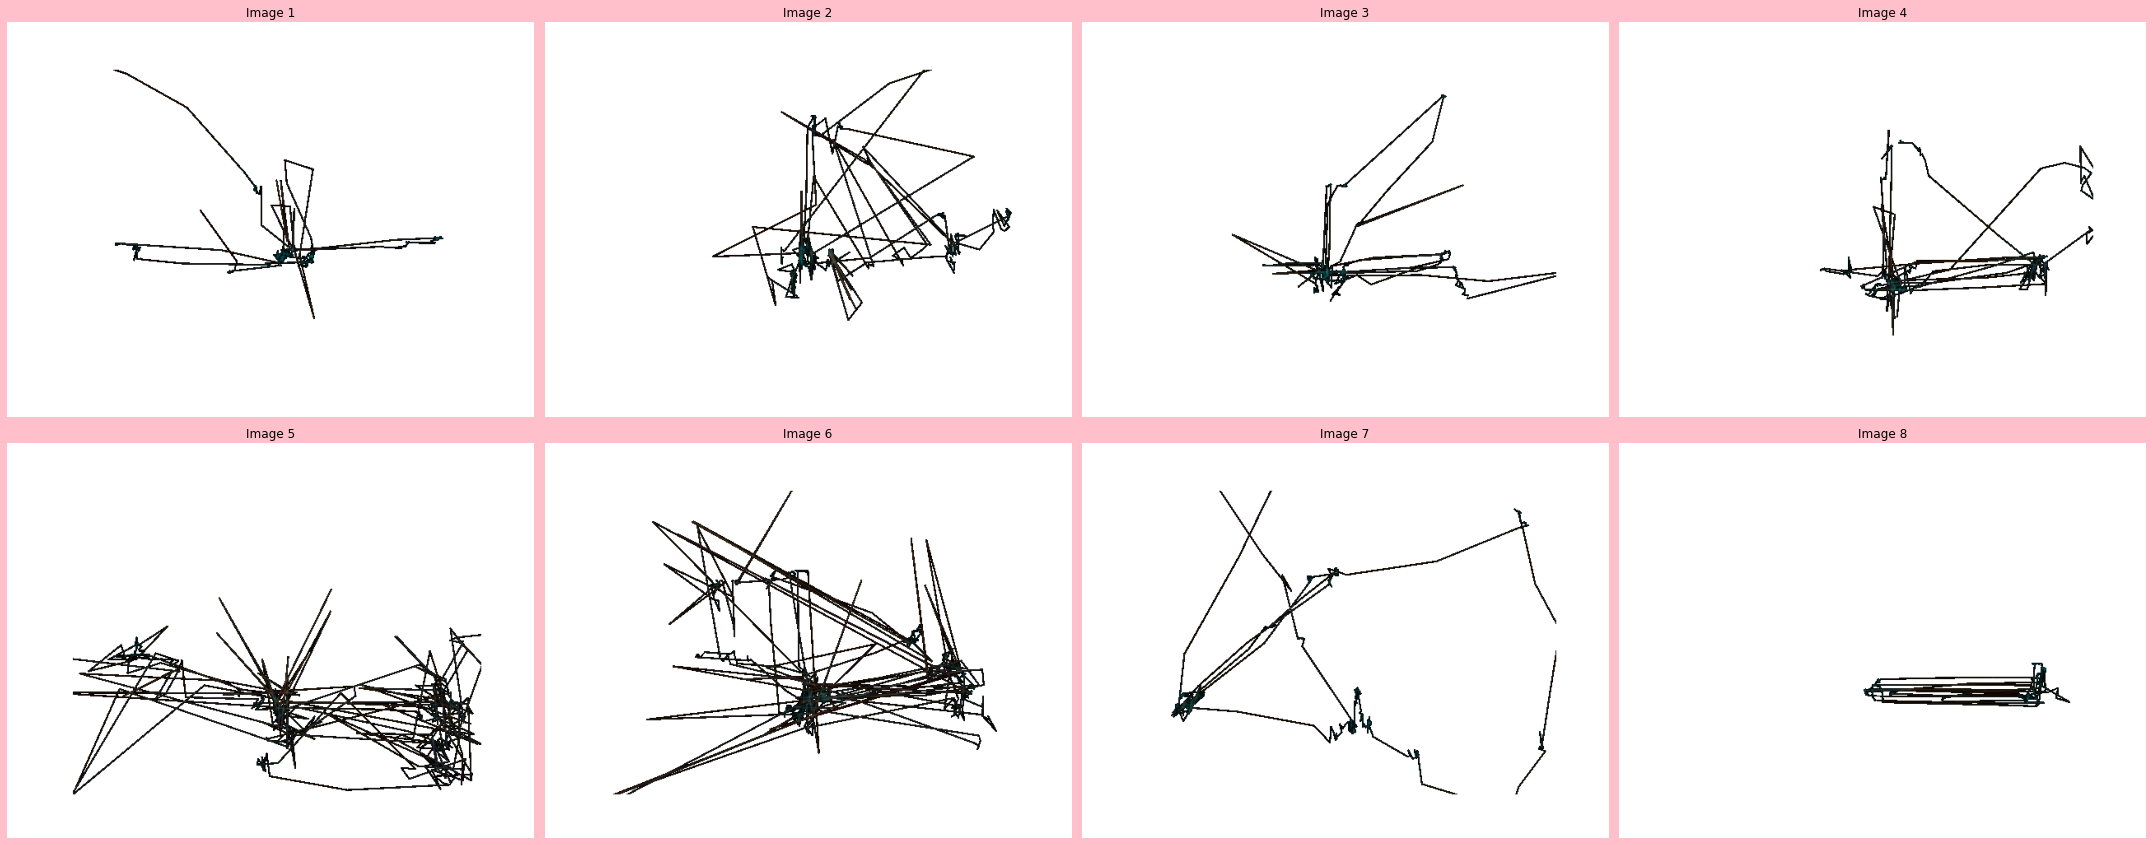

In [23]:
# For TS images

sample_tsimages_white_bg = []

for image in sample_tsimages:
    
    # Create a NumPy array from the image data
    image_data = np.array(image)

    # Create a mask for black regions (assuming black is [0, 0, 0, 255] in RGBA)
    black_mask = np.all(image_data[:, :, :3] == [0, 0, 0], axis=2)

    # Replace black regions with white (255, 255, 255, 255)
    image_data[black_mask] = [255, 255, 255, 255]

    # Convert the modified NumPy array back to an image
    image = Image.fromarray(image_data)

    # Save the modified image
    sample_tsimages_white_bg.append(image)

# Define the number of rows and columns in the grid
rows, cols = 2, 4

# Create a figure and a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(30, 12))
fig.set_facecolor('pink')  # You can use color names or RGB values


# Flatten the 2D grid of subplots
axes = axes.flatten()

# Loop through the images and plot them on the subplots
for i in range(len(sample_tsimages_white_bg)):
    axes[i].imshow(sample_tsimages_white_bg[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    axes[i].set_title(f'Image {i + 1}')
    axes[i].axis('off')  # Turn off axis labels

# Adjust the layout
plt.tight_layout()

# Show the grid of images
plt.show()

### Calculate 'Mean Free Path' and 'Total Eye Movement' for all participants (for all images)

In [24]:
# For non-ASD participants (TC images)

mean_free_path_tc_images = []
total_eye_movement_tc_images = []

for image_pil in tc_images:
    
    # Convert the PIL image to a NumPy array
    image = np.array(image_pil)


    # Convert the image to grayscale for easier processing
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to create a binary mask of gaze points
    _, binary_mask = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)

    # Find contours of the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables for mean free path and total eye movement
    mean_free_path = 0
    total_eye_movement = 0

    # Iterate through the detected contours (gaze points)
    for contour in contours:
        # Calculate the area of the contour as a proxy for gaze point size
        area = cv2.contourArea(contour)
    
        # Update total eye movement (approximated by gaze point area)
        total_eye_movement += area
    
        # Update mean free path based on gaze point area
        # You can customize the calculation based on your needs
        if area > 0:
            mean_free_path += 1 / area

    # Calculate the mean free path
    mean_free_path = len(contours) / mean_free_path

    mean_free_path_tc_images.append(mean_free_path)
    total_eye_movement_tc_images.append(total_eye_movement)


In [25]:
# For ASD participants (TS images)

mean_free_path_ts_images = []
total_eye_movement_ts_images = []

for image_pil in ts_images:
    
    # Convert the PIL image to a NumPy array
    image = np.array(image_pil)


    # Convert the image to grayscale for easier processing
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to create a binary mask of gaze points
    _, binary_mask = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)

    # Find contours of the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables for mean free path and total eye movement
    mean_free_path = 0
    total_eye_movement = 0

    # Iterate through the detected contours (gaze points)
    for contour in contours:
        # Calculate the area of the contour as a proxy for gaze point size
        area = cv2.contourArea(contour)
    
        # Update total eye movement (approximated by gaze point area)
        total_eye_movement += area
    
        # Update mean free path based on gaze point area
        # You can customize the calculation based on your needs
        if area > 0:
            mean_free_path += 1 / area

    # Calculate the mean free path
    mean_free_path = len(contours) / mean_free_path

    mean_free_path_ts_images.append(mean_free_path)
    total_eye_movement_ts_images.append(total_eye_movement)



In [26]:
# Calculate and display average mean_free_path and average total_eye_movement for ASD and non-ASD participants

mfp_tc_images = sum(mean_free_path_tc_images)/len(mean_free_path_tc_images)
mfp_ts_images = sum(mean_free_path_ts_images)/len(mean_free_path_ts_images)
tem_tc_images = sum(total_eye_movement_tc_images)/len(total_eye_movement_tc_images)
tem_ts_images = sum(total_eye_movement_ts_images)/len(total_eye_movement_ts_images)

data = [
    ["non-ASD", int(mfp_tc_images), int(tem_tc_images)],
    ["ASD", int(mfp_ts_images), int(tem_ts_images)],
]

# Define the headers for the table
headers = ["Image Type", "Mean Free Path", "Total Eye Movement"]

# Print the table with a specific table format (e.g., "pretty")
table = tabulate(data, headers, tablefmt="pretty")
print(table)

+------------+----------------+--------------------+
| Image Type | Mean Free Path | Total Eye Movement |
+------------+----------------+--------------------+
|  non-ASD   |      377       |        2742        |
|    ASD     |      2656      |        9523        |
+------------+----------------+--------------------+


### Check corelation of mean_free_path and total_eye_movement with CARS value

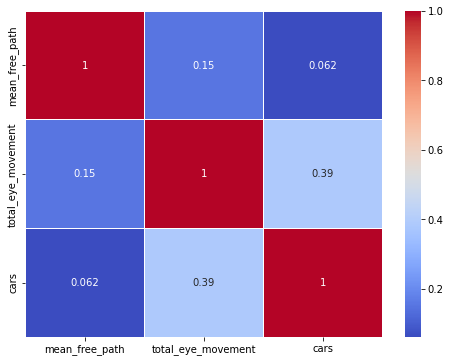

In [27]:
# Create a DataFrame from the lists and Series
data_correlation = {'mean_free_path': mean_free_path_tc_images + mean_free_path_ts_images, 'total_eye_movement' : total_eye_movement_tc_images + total_eye_movement_ts_images, 'cars': df['CARS']}
df_correlation = pd.DataFrame(data_correlation)

# Calculate the correlation matrix
correlation_matrix = df_correlation.corr()

# Create a heatmap with a color map
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

# Show the plot
plt.show()

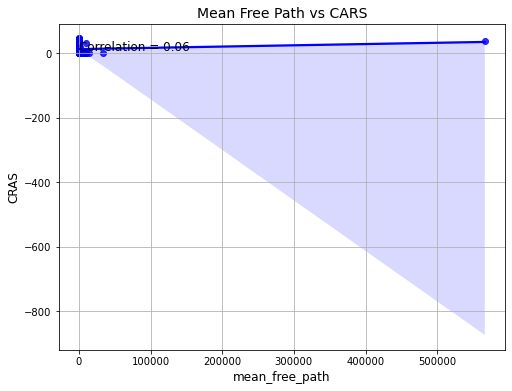

In [28]:
# Sample data as a DataFrame
data = {
    'mean_free_path': mean_free_path_tc_images + mean_free_path_ts_images,
    'CARS': df['CARS']
}

df_eye_tracking_tc = pd.DataFrame(data)

# Create a scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size
sns.regplot(data=df_eye_tracking_tc, x='mean_free_path', y='CARS', marker='o', color='b')

# Calculate the correlation coefficient
correlation_coefficient = df_eye_tracking_tc['mean_free_path'].corr(df_eye_tracking_tc['CARS'])

# Display the correlation coefficient on the plot
plt.text(3, 7, f'Correlation = {correlation_coefficient:.2f}', fontsize=12)

# Set plot labels and title
plt.xlabel('mean_free_path', fontsize=12)
plt.ylabel('CRAS', fontsize=12)
plt.title('Mean Free Path vs CARS', fontsize=14)

# Show the plot
plt.grid(True)
plt.show()

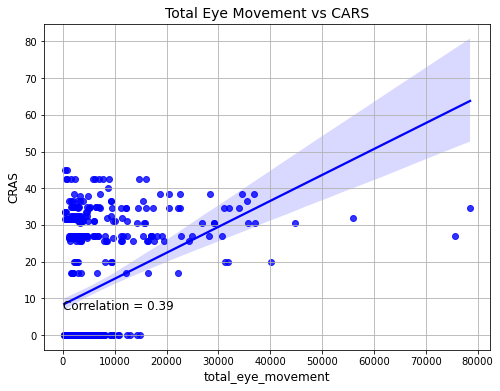

In [29]:
# Sample data as a DataFrame
data = {
    'total_eye_movement': total_eye_movement_tc_images + total_eye_movement_ts_images,
    'CARS': df['CARS']
}

df_eye_tracking_ts = pd.DataFrame(data)

# Create a scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size
sns.regplot(data=df_eye_tracking_ts, x='total_eye_movement', y='CARS', marker='o', color='b')

# Calculate the correlation coefficient
correlation_coefficient = df_eye_tracking_ts['total_eye_movement'].corr(df_eye_tracking_ts['CARS'])

# Display the correlation coefficient on the plot
plt.text(3, 7, f'Correlation = {correlation_coefficient:.2f}', fontsize=12)

# Set plot labels and title
plt.xlabel('total_eye_movement', fontsize=12)
plt.ylabel('CRAS', fontsize=12)
plt.title('Total Eye Movement vs CARS', fontsize=14)

# Show the plot
plt.grid(True)
plt.show()

### Hypothesis 1: Is mean_free_path of the gaze is a good indicator of whether the patient has ASD or not?

In [30]:
# Sample data for two groups (e.g., treatment and control)
group1 = np.array(mean_free_path_tc_images)
group2 = np.array(mean_free_path_ts_images)

# Perform an independent t-test
t_statistic, p_value = stats.ttest_ind(group1, group2)

# Set the significance level (alpha)
alpha = 0.05

# Print the t-statistic and p-value
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Compare the p-value to the significance level to make a decision
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the groups.")


T-statistic: -1.0755551083905805
P-value: 0.28260218021693084
Fail to reject the null hypothesis. There is no significant difference between the groups.


### Hypothesis 2: Is total_eye_movement of the gaze is a good indicator of whether the patient has ASD or not?

In [31]:
# Sample data for two groups (e.g., treatment and control)
group1 = np.array(total_eye_movement_tc_images)
group2 = np.array(total_eye_movement_ts_images)

# Perform an independent t-test
t_statistic, p_value = stats.ttest_ind(group1, group2)

# Set the significance level (alpha)
alpha = 0.05

# Print the t-statistic and p-value
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Compare the p-value to the significance level to make a decision
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the groups.")


T-statistic: -10.073813635251183
P-value: 5.283615142138261e-22
Reject the null hypothesis. There is a significant difference between the groups.


### Quantifying Fixation, Saccade, Velocity, Acceleration and Jerk

In [32]:
# Define color ranges for each color
color_ranges = {
    'cyan': ([90, 170, 100], [120, 255, 255]),  # Cyan
    'yellow': ([20, 100, 100], [40, 255, 255]),  # Yellow
    'white': ([200, 200, 200], [255, 255, 255]),  # White
    'black': ([0, 0, 0], [80, 80, 80]),  # Black
    'red': ([0, 0, 150], [80, 80, 255]),  # Red
    'green': ((35, 100, 100), (85, 255, 255)), # green
    'blue': ([150, 0, 0], [255, 80, 80])  # Blue
}

In [33]:
# For TS images

gaze_features_ts = []
temp = []
count = []
percentage = []

# Load the RGB image
for im in ts_images:
    image = np.array(im)
    
    # Initialize counters for each color
    color_counts = {color: 0 for color in color_ranges}

    # Convert the image to the HSV color space for easier color detection
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Iterate through each pixel and count pixels that match each color
    for color, (lower, upper) in color_ranges.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)
        mask = cv2.inRange(hsv_image, lower, upper)
        color_counts[color] = cv2.countNonZero(mask)

    # Calculate the total number of pixels in the image
    total_pixels = hsv_image.size // 3  # Total number of pixels in the image

    # Calculate percentages and store in a dictionary
    color_percentages = {color: (count / total_pixels) * 100 for color, count in color_counts.items()}

    temp.append(color_counts)
    temp.append(color_percentages)

    gaze_features_ts.append(temp)
    temp = []

# Create an empty list to store flattened dictionaries
flattened_data = []

# Flatten the dictionaries and append them to the flattened_data list
for inner_list in gaze_features_ts:
    flattened_data.append({**inner_list[0], **inner_list[1]})

# Create a DataFrame from the flattened data
df_gaze_ts = pd.DataFrame(flattened_data)

# Print the DataFrame
df_gaze_ts


,cyan,yellow,white,black,red,green,blue
0,0.000000,0.000326,0.0,97.519531,0.0,0.000000,0.047852
1,0.000000,0.000000,0.0,96.746419,0.0,0.000000,0.146810
2,0.000000,0.002279,0.0,97.012695,0.0,0.000651,0.001302
3,0.000000,0.000000,0.0,94.458008,0.0,0.000000,0.001953
4,0.001953,0.000000,0.0,95.693685,0.0,0.000000,0.000326
...,...,...,...,...,...,...,...
214,0.000000,0.001302,0.0,96.583659,0.0,0.000326,0.004557
215,0.000000,0.000326,0.0,98.297852,0.0,0.000000,0.016602
216,0.000000,0.000000,0.0,98.762695,0.0,0.000000,0.023438
217,0.000000,0.000326,0.0,91.771159,0.0,0.000000,0.133464


In [34]:
# For TC images

gaze_features_tc = []
temp = []
count = []
percentage = []

# Load the RGB image
for im in tc_images:
    image = np.array(im)
    
    # Initialize counters for each color
    color_counts = {color: 0 for color in color_ranges}

    # Convert the image to the HSV color space for easier color detection
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Iterate through each pixel and count pixels that match each color
    for color, (lower, upper) in color_ranges.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)
        mask = cv2.inRange(hsv_image, lower, upper)
        color_counts[color] = cv2.countNonZero(mask)

    # Calculate the total number of pixels in the image
    total_pixels = hsv_image.size // 3  # Total number of pixels in the image

    # Calculate percentages and store in a dictionary
    color_percentages = {color: (count / total_pixels) * 100 for color, count in color_counts.items()}

    temp.append(color_counts)
    temp.append(color_percentages)

    gaze_features_tc.append(temp)
    temp = []

# Create an empty list to store flattened dictionaries
flattened_data = []

# Flatten the dictionaries and append them to the flattened_data list
for inner_list in gaze_features_tc:
    flattened_data.append({**inner_list[0], **inner_list[1]})

# Create a DataFrame from the flattened data
df_gaze_tc = pd.DataFrame(flattened_data)

# Print the DataFrame
df_gaze_tc


,cyan,yellow,white,black,red,green,blue
0,0.0,0.003906,0.0,98.941406,0.0,0.0,0.000326
1,0.0,0.001953,0.0,99.207682,0.0,0.0,0.000000
2,0.0,0.002604,0.0,99.480794,0.0,0.0,0.000000
3,0.0,0.000977,0.0,99.107096,0.0,0.0,0.000977
4,0.0,0.001953,0.0,97.506510,0.0,0.0,0.000326
...,...,...,...,...,...,...,...
323,0.0,0.000651,0.0,99.469401,0.0,0.0,0.000000
324,0.0,0.000000,0.0,99.313151,0.0,0.0,0.000000
325,0.0,0.000326,0.0,99.046224,0.0,0.0,0.000000
326,0.0,0.000000,0.0,99.005534,0.0,0.0,0.000000


In [35]:
df_gaze = pd.concat([df_gaze_tc, df_gaze_ts])
df_gaze = df_gaze.reset_index(drop=True)
df_gaze['Index'] = range(1, len(df_gaze) + 1)
df_gaze

,cyan,yellow,white,black,red,green,blue,Index
0,0.0,0.003906,0.0,98.941406,0.0,0.000000,0.000326,1
1,0.0,0.001953,0.0,99.207682,0.0,0.000000,0.000000,2
2,0.0,0.002604,0.0,99.480794,0.0,0.000000,0.000000,3
3,0.0,0.000977,0.0,99.107096,0.0,0.000000,0.000977,4
4,0.0,0.001953,0.0,97.506510,0.0,0.000000,0.000326,5
...,...,...,...,...,...,...,...,...
542,0.0,0.001302,0.0,96.583659,0.0,0.000326,0.004557,543
543,0.0,0.000326,0.0,98.297852,0.0,0.000000,0.016602,544
544,0.0,0.000000,0.0,98.762695,0.0,0.000000,0.023438,545
545,0.0,0.000326,0.0,91.771159,0.0,0.000000,0.133464,546


In [36]:
df_asd = df
df_asd['Index'] = range(1, len(df_asd) + 1)
df_asd

,File,ParticipantID,Age,Gender,CARS,Index
0,TC001_39.png,39.0,8.6,M,0.0,1
1,TC002_39.png,39.0,8.6,M,0.0,2
2,TC003_37.png,37.0,12.8,F,0.0,3
3,TC004_37.png,37.0,12.8,F,0.0,4
4,TC005_37.png,37.0,12.8,F,0.0,5
...,...,...,...,...,...,...
542,TS231_23.png,23.0,3.2,M,32.0,543
543,TS232_23.png,23.0,3.2,M,32.0,544
544,TS233_23.png,23.0,3.2,M,32.0,545
545,TS234_23.png,23.0,3.2,M,32.0,546


In [37]:
df_combined = pd.merge(df_gaze, df_asd, on = 'Index')
df_combined

,cyan,yellow,white,black,red,green,blue,Index,File,ParticipantID,Age,Gender,CARS
0,0.0,0.003906,0.0,98.941406,0.0,0.000000,0.000326,1,TC001_39.png,39.0,8.6,M,0.0
1,0.0,0.001953,0.0,99.207682,0.0,0.000000,0.000000,2,TC002_39.png,39.0,8.6,M,0.0
2,0.0,0.002604,0.0,99.480794,0.0,0.000000,0.000000,3,TC003_37.png,37.0,12.8,F,0.0
3,0.0,0.000977,0.0,99.107096,0.0,0.000000,0.000977,4,TC004_37.png,37.0,12.8,F,0.0
4,0.0,0.001953,0.0,97.506510,0.0,0.000000,0.000326,5,TC005_37.png,37.0,12.8,F,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,0.0,0.001302,0.0,96.583659,0.0,0.000326,0.004557,543,TS231_23.png,23.0,3.2,M,32.0
543,0.0,0.000326,0.0,98.297852,0.0,0.000000,0.016602,544,TS232_23.png,23.0,3.2,M,32.0
544,0.0,0.000000,0.0,98.762695,0.0,0.000000,0.023438,545,TS233_23.png,23.0,3.2,M,32.0
545,0.0,0.000326,0.0,91.771159,0.0,0.000000,0.133464,546,TS234_23.png,23.0,3.2,M,32.0


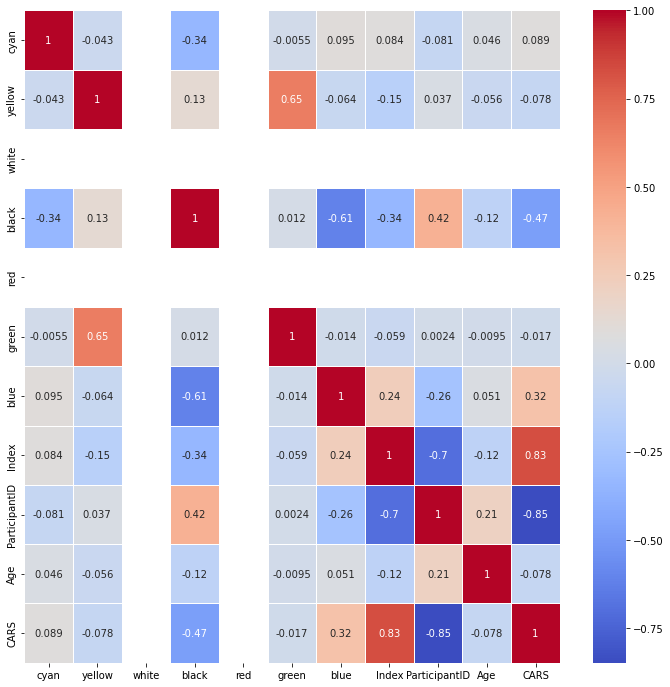

In [38]:
# Calculate the correlation matrix
correlation_matrix_combined = df_combined.corr()

# Create a heatmap with a color map
plt.figure(figsize=(12, 12))  # Set the figure size
sns.heatmap(correlation_matrix_combined, annot=True, cmap='coolwarm', linewidths=.5)

# Show the plot
plt.show()

In [39]:
# Define the dependent (Y) and independent (X) variables
Y = df_combined['CARS']
X = df_combined[['cyan', 'yellow', 'white', 'blue', 'red', 'black', 'green', 'Age']]

# Add a constant (intercept) to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   CARS   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     30.16
Date:                Sun, 01 Oct 2023   Prob (F-statistic):           3.03e-31
Time:                        19:28:41   Log-Likelihood:                -2190.3
No. Observations:                 547   AIC:                             4395.
Df Residuals:                     540   BIC:                             4425.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        599.7728     60.422      9.926      0.0

In [40]:
df_combined['mean_free_path'] = mean_free_path_tc_images + mean_free_path_ts_images
df_combined['total_eye_movement'] = total_eye_movement_tc_images + total_eye_movement_ts_images
df_combined

,cyan,yellow,white,black,red,green,blue,Index,File,ParticipantID,Age,Gender,CARS,mean_free_path,total_eye_movement
0,0.0,0.003906,0.0,98.941406,0.0,0.000000,0.000326,1,TC001_39.png,39.0,8.6,M,0.0,4.017434,1252.5
1,0.0,0.001953,0.0,99.207682,0.0,0.000000,0.000000,2,TC002_39.png,39.0,8.6,M,0.0,2.249405,1470.0
2,0.0,0.002604,0.0,99.480794,0.0,0.000000,0.000000,3,TC003_37.png,37.0,12.8,F,0.0,41.104765,1002.5
3,0.0,0.000977,0.0,99.107096,0.0,0.000000,0.000977,4,TC004_37.png,37.0,12.8,F,0.0,2.308669,1282.5
4,0.0,0.001953,0.0,97.506510,0.0,0.000000,0.000326,5,TC005_37.png,37.0,12.8,F,0.0,1645.419531,5673.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,0.0,0.001302,0.0,96.583659,0.0,0.000326,0.004557,543,TS231_23.png,23.0,3.2,M,32.0,10.371336,11323.5
543,0.0,0.000326,0.0,98.297852,0.0,0.000000,0.016602,544,TS232_23.png,23.0,3.2,M,32.0,5.700152,2989.5
544,0.0,0.000000,0.0,98.762695,0.0,0.000000,0.023438,545,TS233_23.png,23.0,3.2,M,32.0,2.129763,2184.0
545,0.0,0.000326,0.0,91.771159,0.0,0.000000,0.133464,546,TS234_23.png,23.0,3.2,M,32.0,8.382528,55961.0


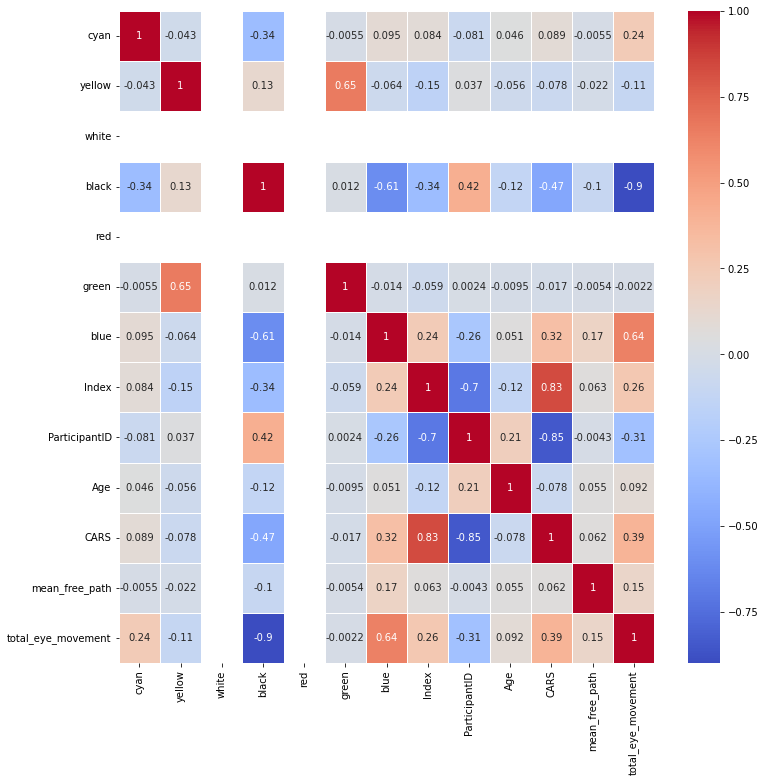

In [41]:
# Calculate the correlation matrix
correlation_matrix_combined = df_combined.corr()

# Create a heatmap with a color map
plt.figure(figsize=(12, 12))  # Set the figure size
sns.heatmap(correlation_matrix_combined, annot=True, cmap='coolwarm', linewidths=.5)

# Show the plot
plt.show()

In [42]:
# Define the dependent (Y) and independent (X) variables
Y = df_combined['CARS']
X = df_combined[['cyan', 'yellow', 'white', 'blue', 'red', 'black', 'green', 'Age', 'mean_free_path', 'total_eye_movement']]

# Add a constant (intercept) to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   CARS   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     24.38
Date:                Sun, 01 Oct 2023   Prob (F-statistic):           4.62e-32
Time:                        19:28:42   Log-Likelihood:                -2184.7
No. Observations:                 547   AIC:                             4387.
Df Residuals:                     538   BIC:                             4426.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                893.6199    107